In [1]:
pwd

'/content'

In [2]:
!git clone https://github.com/theschoolof-ai/JEDI.git

Cloning into 'JEDI'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 341 (delta 1), reused 4 (delta 1), pack-reused 332
Receiving objects: 100% (341/341), 240.14 MiB | 38.41 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [3]:
cd /content/JEDI/tsai.jedi

/content/JEDI/tsai.jedi


In [4]:
import sys
sys.path.append('Models/')
from S7 import model_summary
from S9_resnet import resnet18

In [5]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 5.3MB/s 
     |████████████████████████████████| 952kB 19.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=fc42e0820d4cb64c52bd6a339b5bfff3a65f8f08fb28df7ac3e497db63285b20
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
import sys
sys.path.append('Models/')
from S9_resnet import resnet18
from S7 import model_summary
sys.path.append(".")
from lr_finder import LRFinder
import torch.nn as nn
from dataloader import test_loader_CIFAR10_alb, train_loader_CIFAR10_alb
from aftereffects import get_image_with_target, plots
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
import config

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [7]:
model_ = resnet18(num_classes=10, pretrained=False).to(config.device)
print(model_summary(model_, config.input_size_CIFAR10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

##LR FINDER


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-02


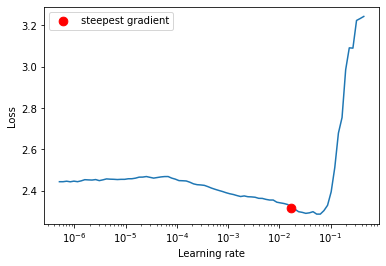

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_alb, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [9]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from Engine_train_test import train, test
optimizer = optim.SGD(model_.parameters(), lr=1.71E-02, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

valid_acc = []
valid_loss = []
train_acc = []
train_loss = []
l1_regularization = [0, 0]
for epoch in range(1, 50):
    train_a, train_l = train(model_, config.device, train_loader_CIFAR10_alb, optimizer, epoch, l1_regularization=[0, 1])
    train_acc.append(train_a)
    train_loss.append(train_l)
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb)
    scheduler.step(valid_l)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    valid_loss.append(valid_l)

Epoch: 1,LR: 0.0171.
Train set: train Average loss: 1.1728, train_Accuracy: 19788/50000 (39.5760%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 5214/10000 (52.1400%)



Epoch: 2,LR: 0.0171.
Train set: train Average loss: 1.2876, train_Accuracy: 27665/50000 (55.3300%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6360/10000 (63.6000%)



Epoch: 3,LR: 0.0171.
Train set: train Average loss: 0.9687, train_Accuracy: 32343/50000 (64.6860%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 6408/10000 (64.0800%)



Epoch: 4,LR: 0.0171.
Train set: train Average loss: 0.9086, train_Accuracy: 35044/50000 (70.0880%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7229/10000 (72.2900%)



Epoch: 5,LR: 0.0171.
Train set: train Average loss: 0.6814, train_Accuracy: 36736/50000 (73.4720%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7736/10000 (77.3600%)



Epoch: 6,LR: 0.0171.
Train set: train Average loss: 0.7552, train_Accuracy: 38191/50000 (76.3820%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7704/10000 (77.0400%)



Epoch: 7,LR: 0.0171.
Train set: train Average loss: 0.4205, train_Accuracy: 39219/50000 (78.4380%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7959/10000 (79.5900%)



Epoch: 8,LR: 0.0171.
Train set: train Average loss: 0.4674, train_Accuracy: 40415/50000 (80.8300%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7963/10000 (79.6300%)



Epoch: 9,LR: 0.0171.
Train set: train Average loss: 0.5432, train_Accuracy: 40914/50000 (81.8280%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8109/10000 (81.0900%)



Epoch: 10,LR: 0.0171.
Train set: train Average loss: 0.7315, train_Accuracy: 41483/50000 (82.9660%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7897/10000 (78.9700%)



Epoch: 11,LR: 0.0171.
Train set: train Average loss: 0.5358, train_Accuracy: 41985/50000 (83.9700%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8394/10000 (83.9400%)



Epoch: 12,LR: 0.0171.
Train set: train Average loss: 0.5239, train_Accuracy: 42492/50000 (84.9840%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8334/10000 (83.3400%)



Epoch: 13,LR: 0.0171.
Train set: train Average loss: 0.3046, train_Accuracy: 42732/50000 (85.4640%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8276/10000 (82.7600%)



Epoch: 14,LR: 0.0171.
Train set: train Average loss: 0.4253, train_Accuracy: 43210/50000 (86.4200%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8426/10000 (84.2600%)



Epoch: 15,LR: 0.0171.
Train set: train Average loss: 0.3476, train_Accuracy: 43620/50000 (87.2400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8403/10000 (84.0300%)



Epoch: 16,LR: 0.0171.
Train set: train Average loss: 0.5323, train_Accuracy: 43854/50000 (87.7080%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8238/10000 (82.3800%)



Epoch: 17,LR: 0.0171.
Train set: train Average loss: 0.4424, train_Accuracy: 44167/50000 (88.3340%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8503/10000 (85.0300%)



Epoch: 18,LR: 0.0171.
Train set: train Average loss: 0.2578, train_Accuracy: 44352/50000 (88.7040%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8540/10000 (85.4000%)



Epoch: 19,LR: 0.0171.
Train set: train Average loss: 0.3529, train_Accuracy: 44510/50000 (89.0200%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8575/10000 (85.7500%)



Epoch: 20,LR: 0.0171.
Train set: train Average loss: 0.2462, train_Accuracy: 44736/50000 (89.4720%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8539/10000 (85.3900%)



Epoch: 21,LR: 0.0171.
Train set: train Average loss: 0.2448, train_Accuracy: 44984/50000 (89.9680%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8555/10000 (85.5500%)



Epoch: 22,LR: 0.0171.
Train set: train Average loss: 0.1684, train_Accuracy: 45115/50000 (90.2300%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8634/10000 (86.3400%)



Epoch: 23,LR: 0.0171.
Train set: train Average loss: 0.2857, train_Accuracy: 45016/50000 (90.0320%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8658/10000 (86.5800%)



Epoch: 24,LR: 0.0171.
Train set: train Average loss: 0.3290, train_Accuracy: 45401/50000 (90.8020%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8629/10000 (86.2900%)



Epoch: 25,LR: 0.0171.
Train set: train Average loss: 0.2671, train_Accuracy: 45606/50000 (91.2120%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8405/10000 (84.0500%)



Epoch: 26,LR: 0.0171.
Train set: train Average loss: 0.3225, train_Accuracy: 45604/50000 (91.2080%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8618/10000 (86.1800%)



Epoch: 27,LR: 0.0171.
Train set: train Average loss: 0.3354, train_Accuracy: 45748/50000 (91.4960%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8599/10000 (85.9900%)



Epoch: 28,LR: 0.0171.
Train set: train Average loss: 0.1626, train_Accuracy: 45885/50000 (91.7700%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8707/10000 (87.0700%)



Epoch: 29,LR: 0.0017100000000000001.
Train set: train Average loss: 0.1892, train_Accuracy: 47355/50000 (94.7100%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9034/10000 (90.3400%)



Epoch: 30,LR: 0.0017100000000000001.
Train set: train Average loss: 0.1058, train_Accuracy: 47944/50000 (95.8880%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9083/10000 (90.8300%)



Epoch: 31,LR: 0.0017100000000000001.
Train set: train Average loss: 0.1251, train_Accuracy: 48097/50000 (96.1940%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9089/10000 (90.8900%)



Epoch: 32,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0714, train_Accuracy: 48172/50000 (96.3440%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9091/10000 (90.9100%)



Epoch: 33,LR: 0.0017100000000000001.
Train set: train Average loss: 0.2216, train_Accuracy: 48315/50000 (96.6300%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9093/10000 (90.9300%)



Epoch: 34,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0830, train_Accuracy: 48468/50000 (96.9360%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9098/10000 (90.9800%)



Epoch: 35,LR: 0.0017100000000000001.
Train set: train Average loss: 0.2217, train_Accuracy: 48468/50000 (96.9360%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9094/10000 (90.9400%)



Epoch: 36,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0428, train_Accuracy: 48540/50000 (97.0800%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9109/10000 (91.0900%)



Epoch: 37,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0330, train_Accuracy: 48522/50000 (97.0440%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9079/10000 (90.7900%)



Epoch: 38,LR: 0.0017100000000000001.
Train set: train Average loss: 0.2345, train_Accuracy: 48620/50000 (97.2400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9125/10000 (91.2500%)



Epoch: 39,LR: 0.0017100000000000001.
Train set: train Average loss: 0.1592, train_Accuracy: 48619/50000 (97.2380%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9098/10000 (90.9800%)



Epoch: 40,LR: 0.0017100000000000001.
Train set: train Average loss: 0.1215, train_Accuracy: 48711/50000 (97.4220%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9101/10000 (91.0100%)



Epoch: 41,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0584, train_Accuracy: 48676/50000 (97.3520%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9092/10000 (90.9200%)



Epoch: 42,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0138, train_Accuracy: 48735/50000 (97.4700%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9116/10000 (91.1600%)



Epoch: 43,LR: 0.0017100000000000001.
Train set: train Average loss: 0.0735, train_Accuracy: 48745/50000 (97.4900%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9099/10000 (90.9900%)



Epoch: 44,LR: 0.00017100000000000004.
Train set: train Average loss: 0.0368, train_Accuracy: 48807/50000 (97.6140%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9116/10000 (91.1600%)



Epoch: 45,LR: 0.00017100000000000004.
Train set: train Average loss: 0.1056, train_Accuracy: 48850/50000 (97.7000%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9129/10000 (91.2900%)



Epoch: 46,LR: 0.00017100000000000004.
Train set: train Average loss: 0.0544, train_Accuracy: 48886/50000 (97.7720%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9125/10000 (91.2500%)



Epoch: 47,LR: 0.00017100000000000004.
Train set: train Average loss: 0.0992, train_Accuracy: 48908/50000 (97.8160%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9130/10000 (91.3000%)



Epoch: 48,LR: 0.00017100000000000004.
Train set: train Average loss: 0.1485, train_Accuracy: 48869/50000 (97.7380%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9126/10000 (91.2600%)



Epoch: 49,LR: 0.00017100000000000004.
Train set: train Average loss: 0.0925, train_Accuracy: 48872/50000 (97.7440%)


Test set: Average loss: 0.0023, Accuracy: 9125/10000 (91.2500%)



In [10]:
len(train_loss)
len(valid_loss)

49

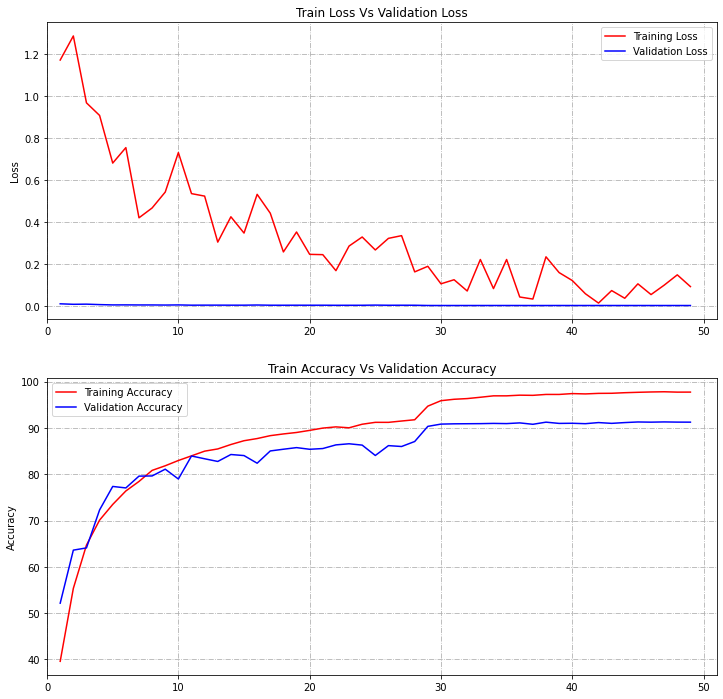

In [12]:
import matplotlib.pyplot as plt
epoch = 49
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Loss')
plt.title('Train Loss Vs Validation Loss')
plt.plot(range(1, epoch+1), train_loss[:epoch+1], 'r', label='Training Loss')
plt.plot(range(1, epoch+1), valid_loss[:epoch+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)

ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.title('Train Accuracy Vs Validation Accuracy')
plt.plot(range(1, epoch+1), train_acc[:epoch+1], 'r', label='Training Accuracy')
plt.plot(range(1, epoch+1), valid_acc[:epoch+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [14]:
#torch.save(model_, 'JEDI/tsai.jedi/model_objects/s10.pt')

In [16]:
pwd

'/content/JEDI/tsai.jedi'

In [ ]:
from dataloader import classes_CIFAR10
path = 'model_objects/s10.pt'
data_t,target_t,pred_t,data_,target_,pred_ = get_image_with_target(model_path=path, number_of_img=25, dataloader=test_loader_CIFAR10_alb,
                                              is_classified = False,return_torch = 'Both')
title = ['target:' + classes_CIFAR10[i] + '\n' + 'pred:' + classes_CIFAR10[j] for i, j in zip(target_, pred_)] 


In [20]:
data_t = data_t.permute(0,3,1,2)
data_t.shape,target_t.shape

(torch.Size([25, 3, 32, 32]), torch.Size([25]))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

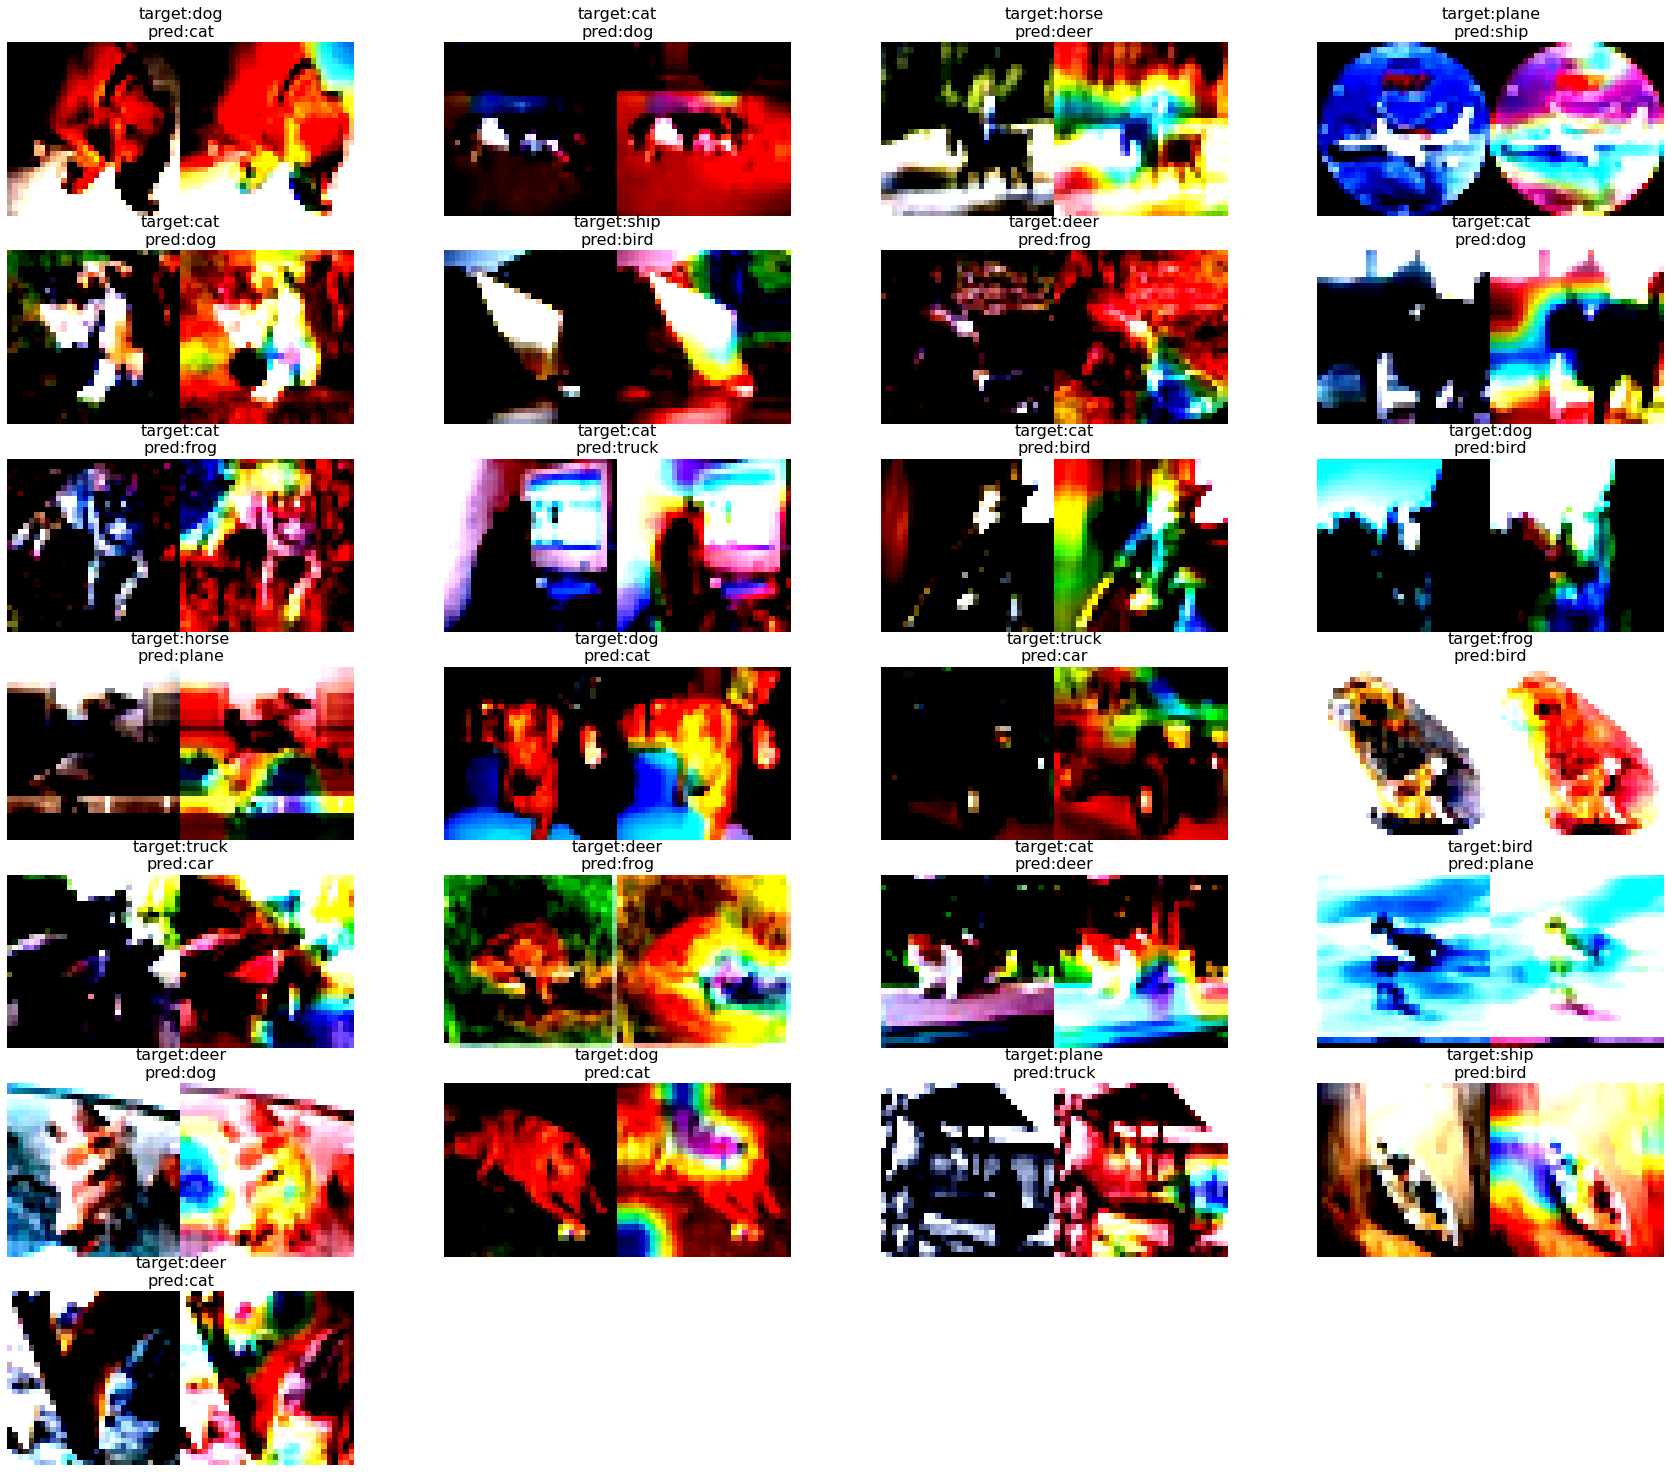

In [21]:
import torch
model = torch.load(path)
import config
from gradcam import GradCam
from gradcam import show_cam_on_image
gradcam_img = []
for idx in range(len(data_t)): 
    ip = data_t.index_select(0,torch.tensor(idx))
    grad_cam = GradCam(model=model, feature_module=model.layer3,target_layer_names=["1"], use_cuda=config.use_cuda)
    mask = grad_cam(ip)
    op_img = show_cam_on_image(ip.squeeze().permute(1,2,0), mask)
    gradcam_img.append(op_img)
plots(gradcam_img,titles=title, rows = 8,figsize = (30,30))